#Redes Neuronales - Trabajo Práctico Número 1
#Autor: Franco Scapolla

# Notebook 4: Problema de regresión


Para este problema se trabaja con el dataset MNIST. Se utiliza información adicional de https://github.com/dccastro/Morpho-MNIST, que incluye para cada imagen características adicionales como pueden ser largo del trazo, inclinación del número, etc.

# 4.1 Importe de librerías

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from keras.datasets import mnist
from keras.models import Sequential, Model, clone_model
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, concatenate, Embedding, Input
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.initializers import RandomNormal, Zeros, glorot_normal, glorot_uniform
from keras.utils import to_categorical
from keras import regularizers

# 4.2 Carga y preprocesamiento de datos

In [ ]:
#Cargo los datos de train y test
(x_train, y_train) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("/content/drive/MyDrive/Redes Neuronales/TP1/train-morpho.csv")
test_morpho = pd.read_csv("/content/drive/MyDrive/Redes Neuronales/TP1/t10k-morpho.csv")

In [ ]:
#Normalizo los datos
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
#Tamaño del dataset de train
x_train.shape

(60000, 28, 28)

In [ ]:
#Tamaño del dataset de test
x_test.shape

(10000, 28, 28)

In [ ]:
#Veo la información que brinda Morpho-MNIST
train_morpho.describe()

,index,area,length,thickness,slant,width,height
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,29999.500000,103.084953,43.346860,2.635180,0.102871,13.073770,19.106516
std,17320.652413,34.221830,11.371704,0.685736,0.253964,3.908851,1.166468
min,0.000000,22.750000,12.906854,1.032670,-0.862740,2.898675,8.194290
25%,14999.750000,78.312500,36.806349,2.151531,-0.072172,11.131060,19.126604
50%,29999.500000,100.375000,44.166631,2.535462,0.102710,13.456105,19.432432
75%,44999.250000,124.500000,51.256859,3.000212,0.284031,15.801113,19.647313
max,59999.000000,315.125000,93.521338,9.598604,1.066282,23.541878,20.445764


In [ ]:
test_morpho.describe()

,index,area,length,thickness,slant,width,height
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,104.473700,42.859552,2.691419,0.087973,13.065588,19.121089
std,2886.89568,34.644606,11.223693,0.700073,0.244906,3.858095,1.131176
min,0.00000,15.750000,10.717514,1.026260,-0.764457,3.084083,8.657789
25%,2499.75000,79.937500,36.485728,2.198631,-0.082323,11.241026,19.122323
50%,4999.50000,102.125000,43.773864,2.579508,0.084547,13.493534,19.419158
75%,7499.25000,125.687500,50.655592,3.054476,0.262059,15.673334,19.635971
max,9999.00000,258.375000,77.890873,8.590270,0.817026,22.209017,20.368900


# 4.3 Análisis Exploratorio de Datos

# 4.3.1 Visualización de algunas instancias

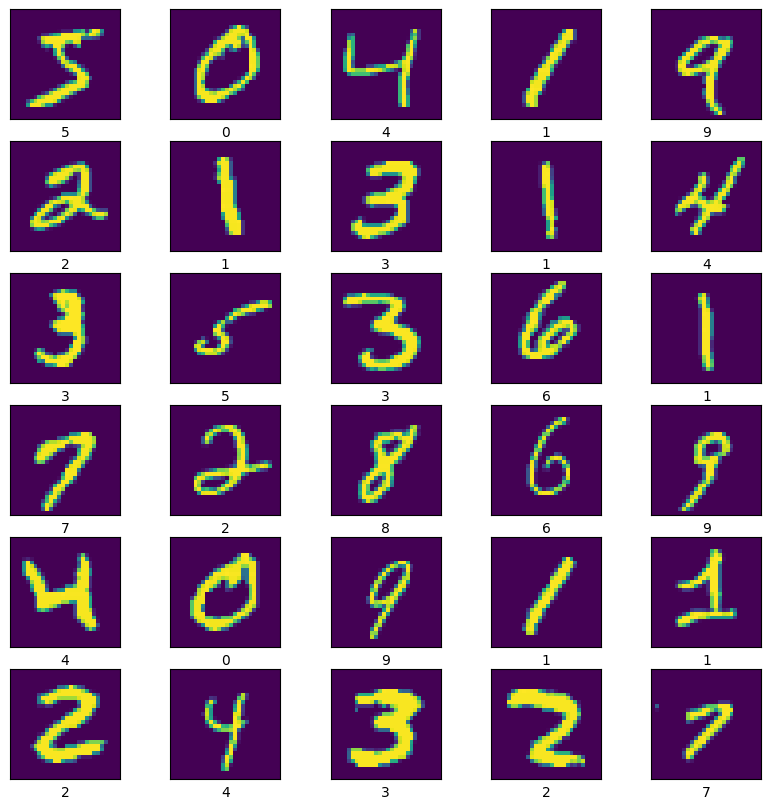

In [ ]:
#Imprimo las primeras 30 imágenes de train con sus correspondientes labels
plt.figure(figsize = (10,10))
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.xlabel(y_train[i])

# 4.3.2 Distribución de clases

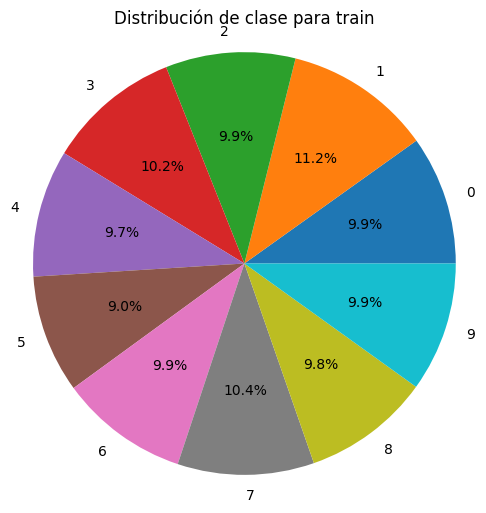

In [ ]:
#Veo cómo se distribuyen las 60000 imágenes de train en las distintas clases
plt.figure(figsize=(6, 6))
plt.pie(np.bincount(y_train), labels=range(10), autopct='%1.1f%%')
plt.title('Distribución de clase para train')
plt.axis('equal')
plt.show()

# 4.3.3 Histograma de inclinación para cada clase

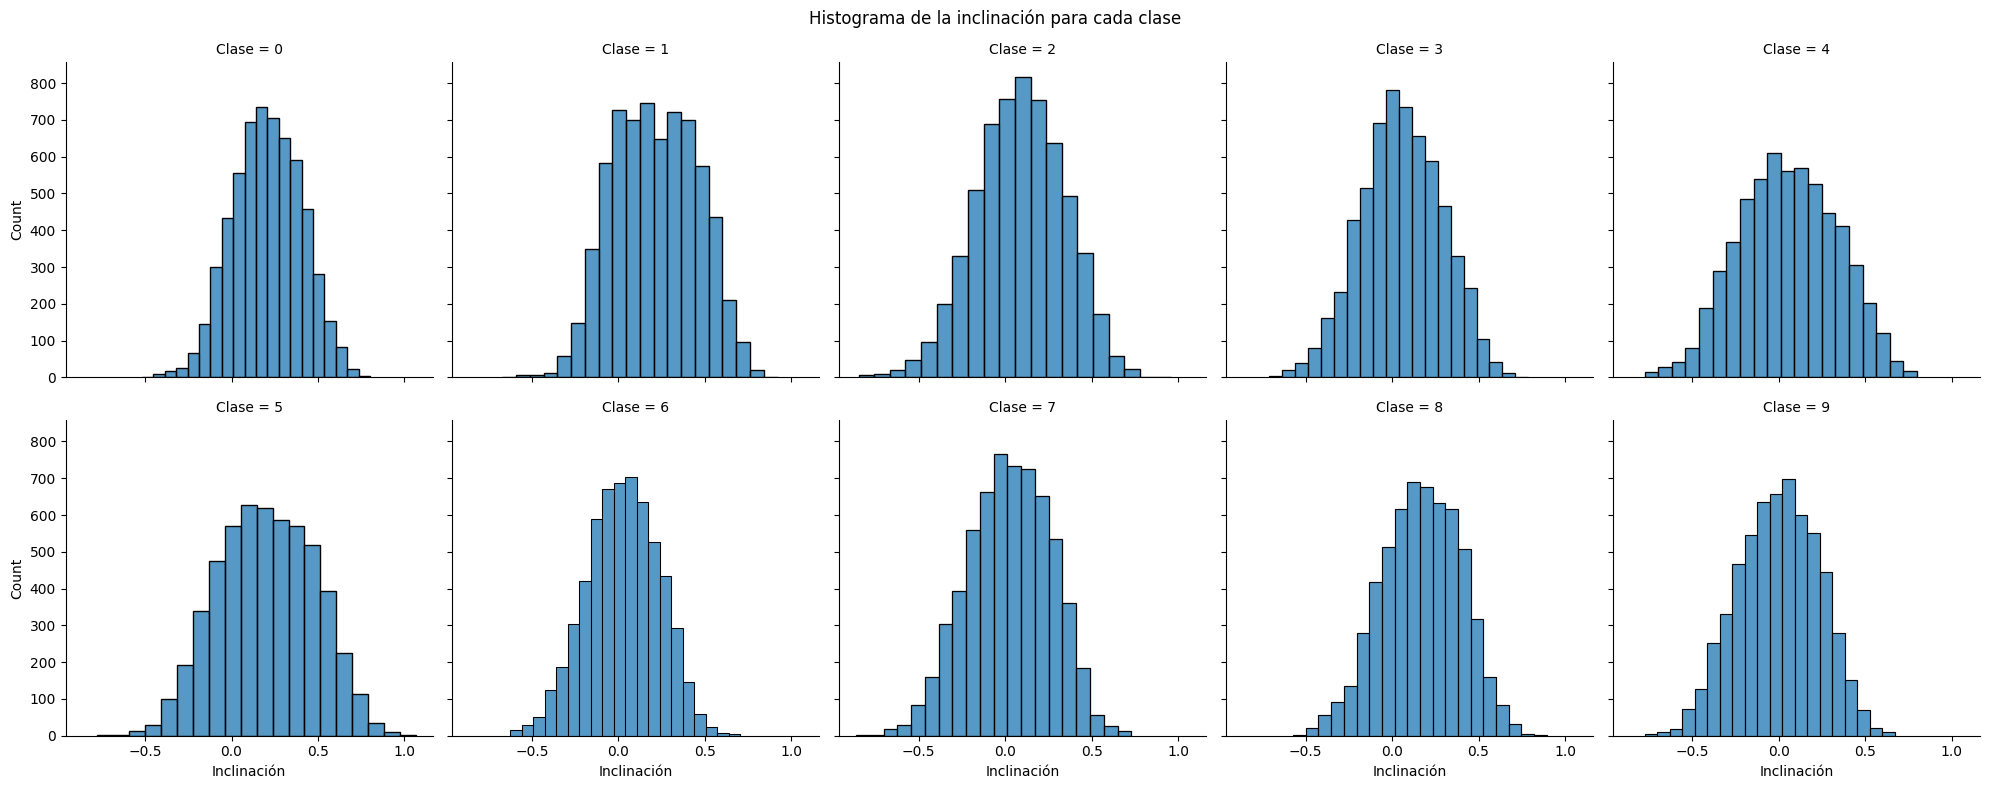

In [ ]:
# (Referencia https://stackoverflow.com/questions/75635729/how-to-set-multiple-histograms-in-a-facetgrid)

# Junto la información del label 
slant_data = train_morpho[['slant']].copy()
slant_data["Clase"] = y_train

#Grafico los histogramas.
g = sns.FacetGrid(slant_data, col="Clase", col_wrap=5, height=4)
g.map(sns.histplot, 'slant', bins=20)

g.set_axis_labels('Inclinación', 'Count')
g.fig.suptitle("Histograma de la inclinación para cada clase")
plt.tight_layout()

plt.show()


# 4.3.4 Scatter plots para ver relación entre inclinación y otras características morfológicas

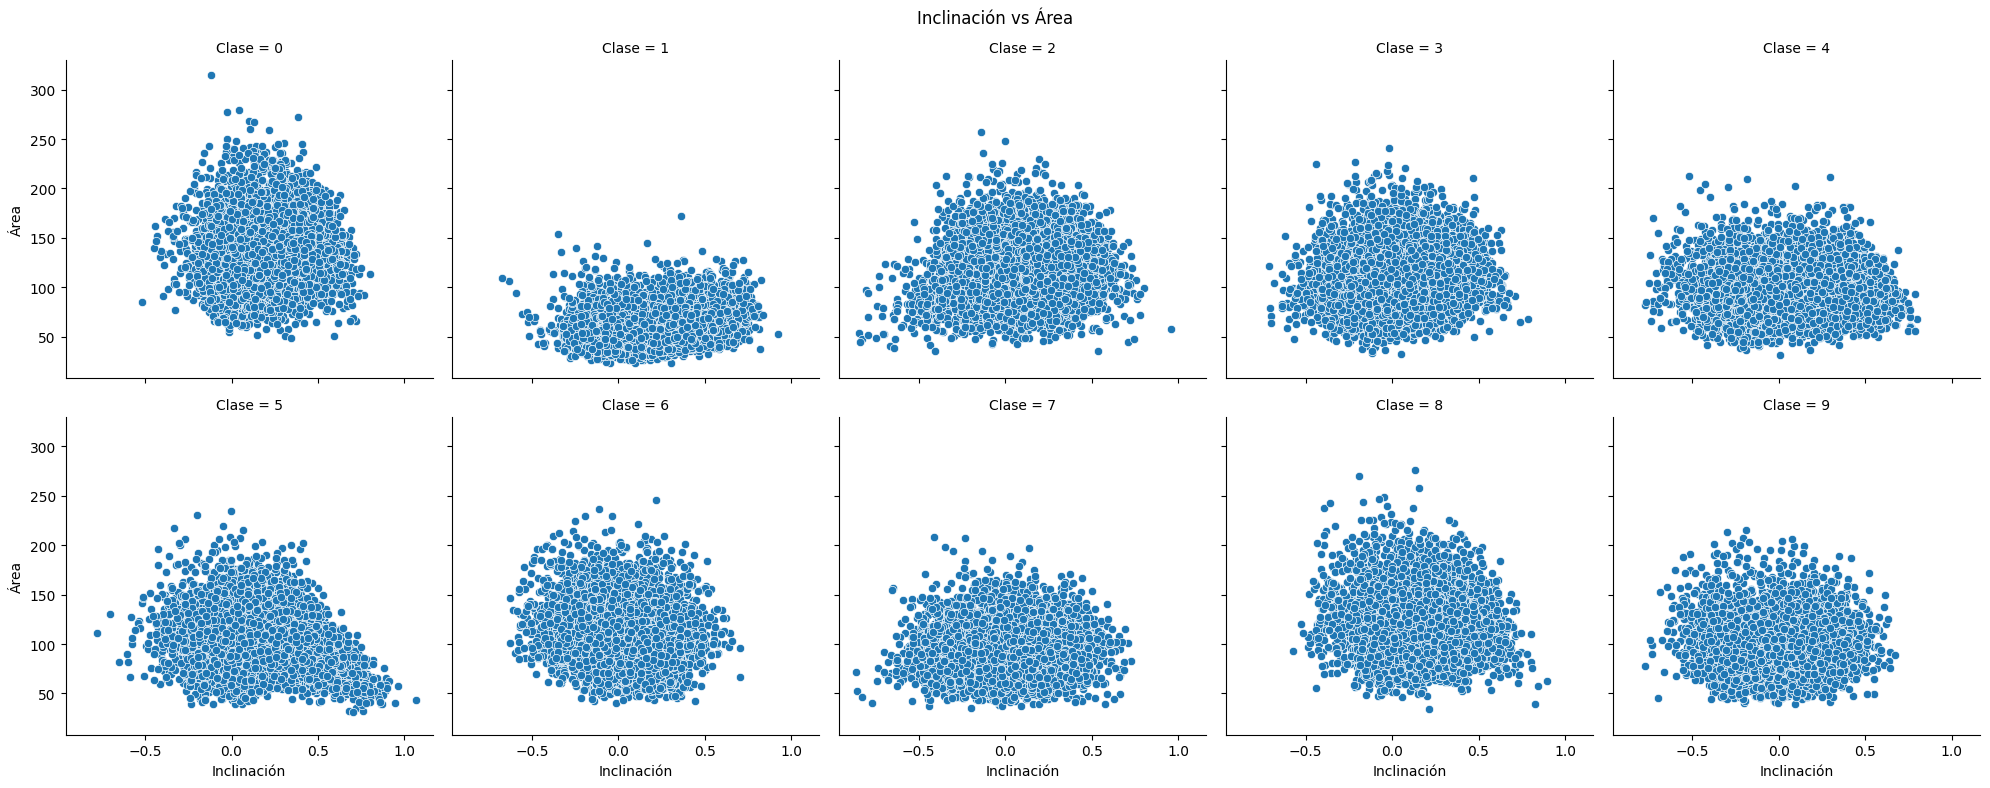

In [ ]:
#Inclinación vs área

#Junto la información del label 
scatter_data = train_morpho[['slant', 'area']].copy()
scatter_data["Clase"] = y_train

#Grafico los scatter plots
g = sns.FacetGrid(scatter_data, col="Clase", col_wrap=5, height=4)
g.map(sns.scatterplot, 'slant', 'area')

g.set_axis_labels("Inclinación", "Área")
g.fig.suptitle("Inclinación vs Área")
plt.tight_layout()

plt.show()


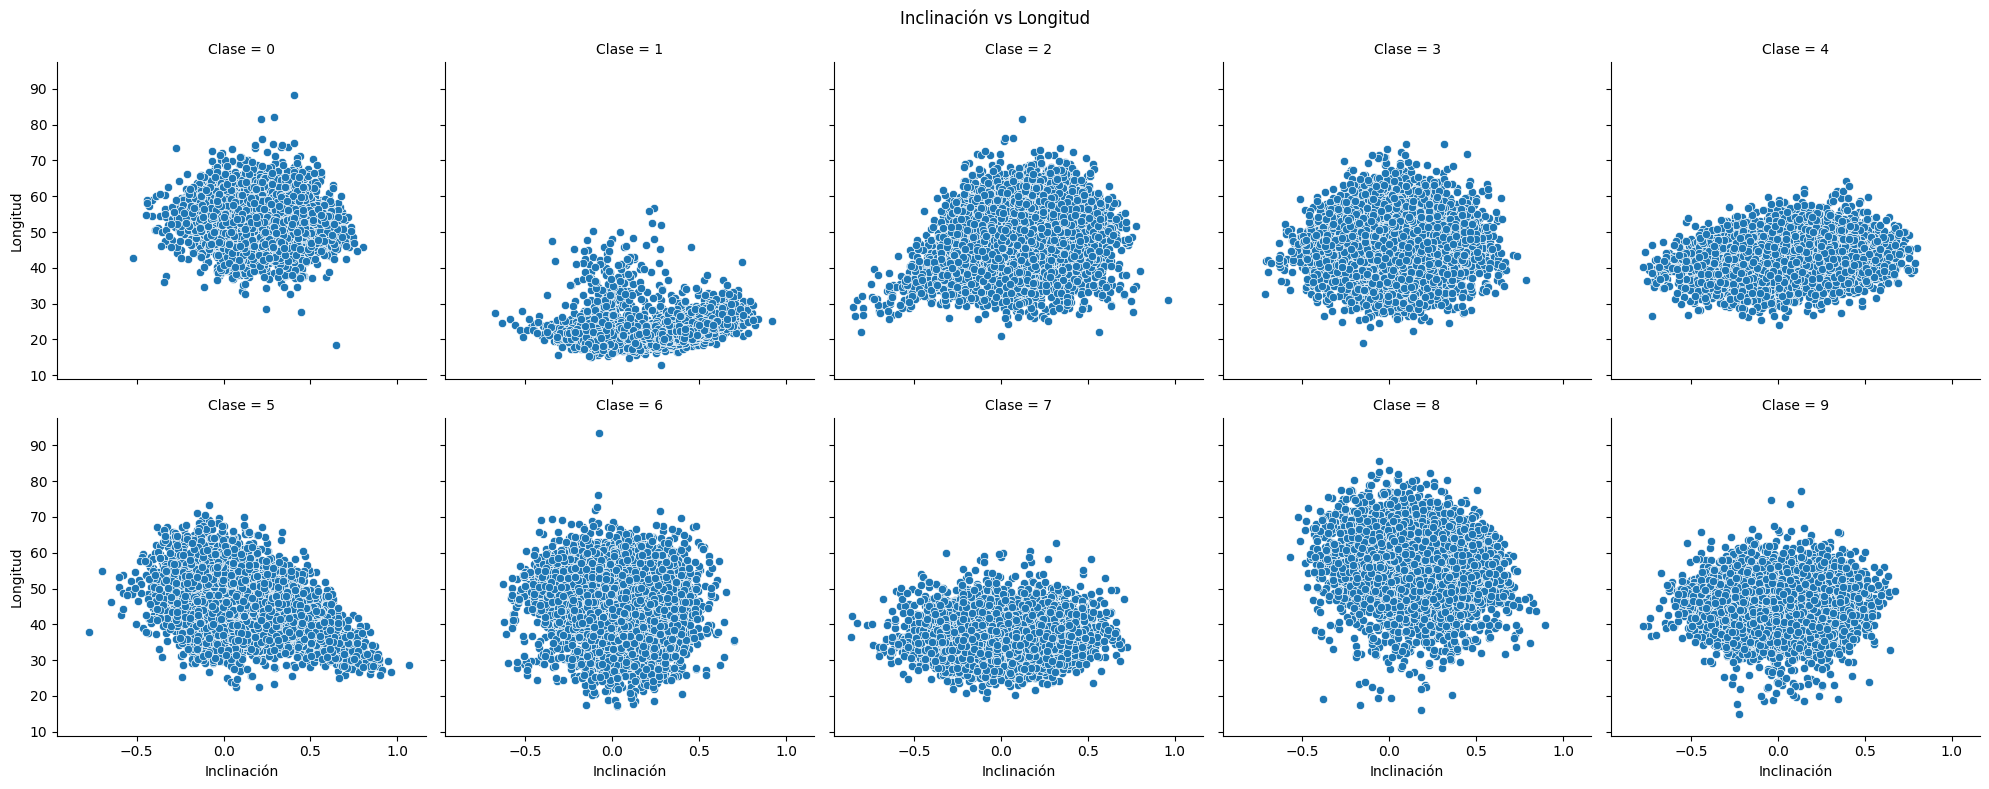

In [ ]:
#Inclinación vs longitud

#Junto la información del label 
scatter_data = train_morpho[['slant', 'length']].copy()
scatter_data["Clase"] = y_train

#Grafico los scatter plots
g = sns.FacetGrid(scatter_data, col="Clase", col_wrap=5, height=4)
g.map(sns.scatterplot, 'slant', 'length')

g.set_axis_labels("Inclinación", "Longitud")
g.fig.suptitle("Inclinación vs Longitud")
plt.tight_layout()

plt.show()

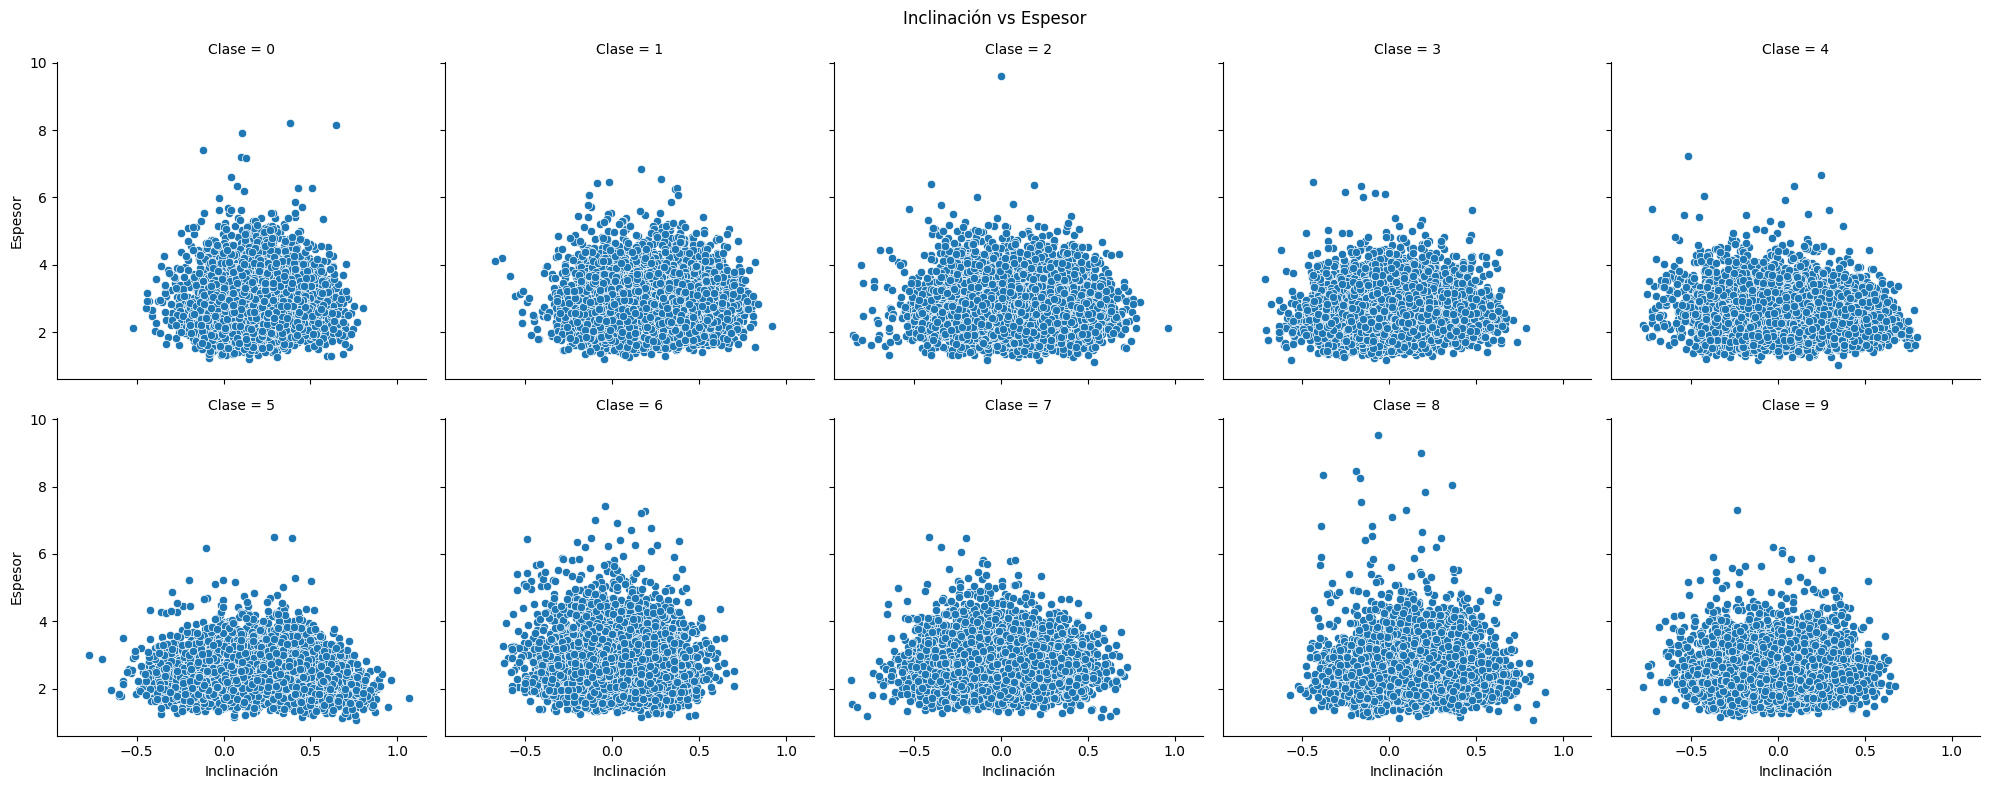

In [ ]:
#Inclinación vs espesor

#Junto la información del label 
scatter_data = train_morpho[['slant', 'thickness']].copy()
scatter_data["Clase"] = y_train

#Grafico los scatter plots
g = sns.FacetGrid(scatter_data, col="Clase", col_wrap=5, height=4)
g.map(sns.scatterplot, 'slant', 'thickness')

g.set_axis_labels("Inclinación", "Espesor")
g.fig.suptitle("Inclinación vs Espesor")
plt.tight_layout()

plt.show()

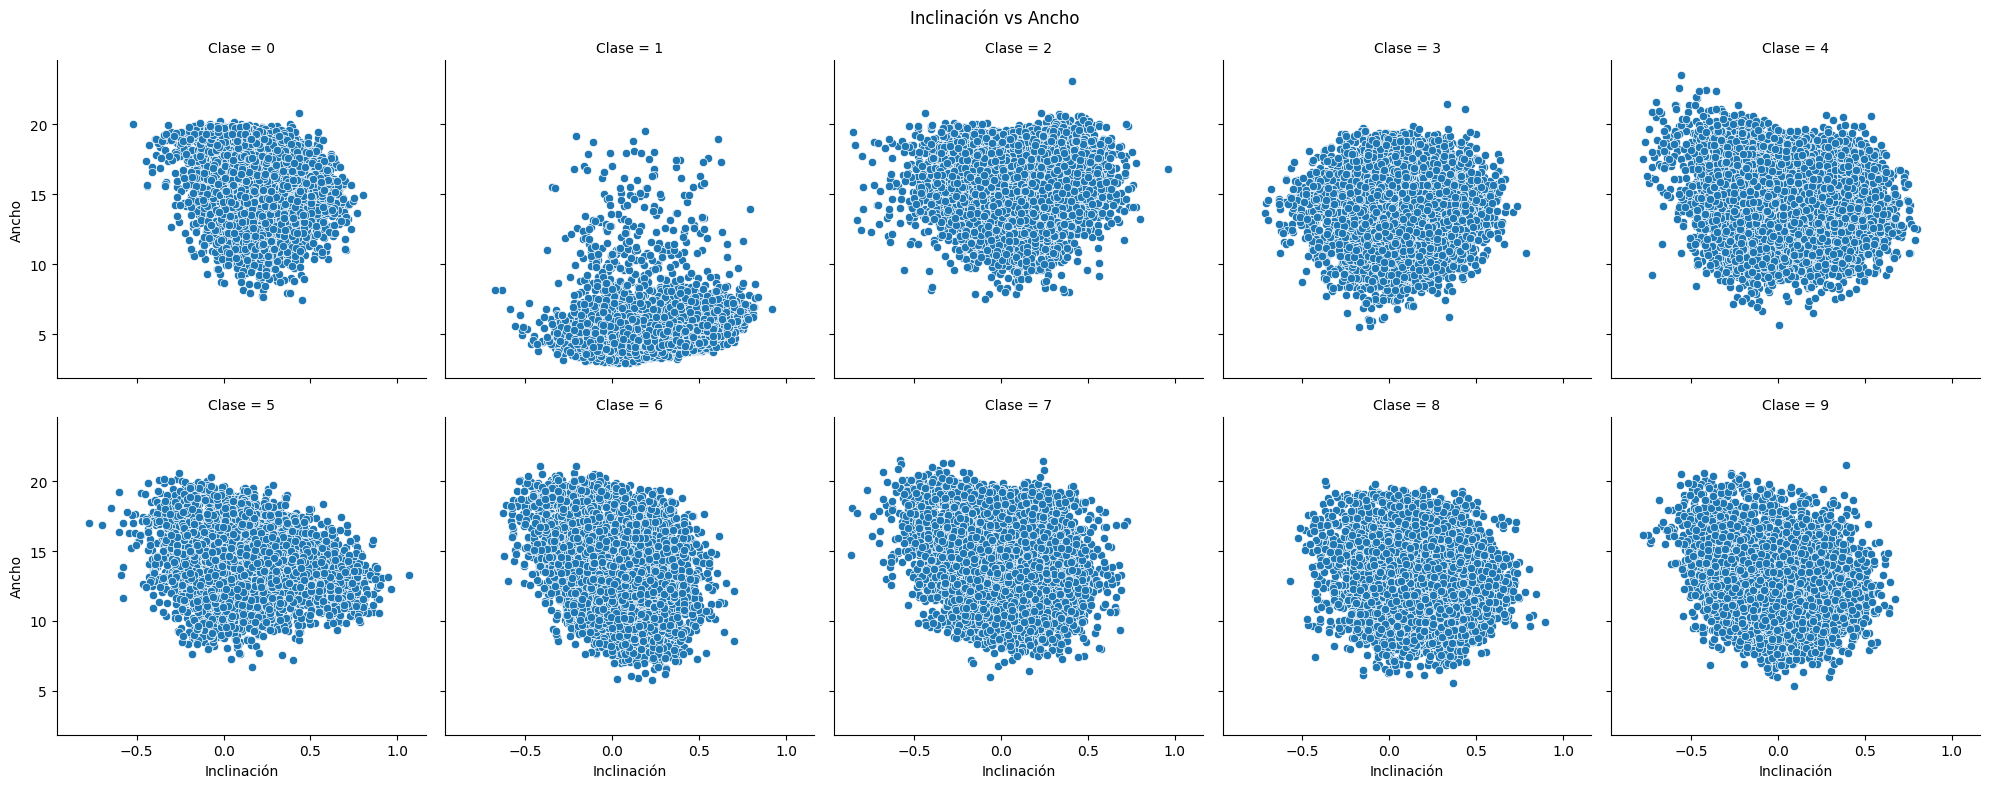

In [ ]:
#Inclinación vs ancho

#Junto la información del label 
scatter_data = train_morpho[['slant', 'width']].copy()
scatter_data["Clase"] = y_train

#Grafico los scatter plots
g = sns.FacetGrid(scatter_data, col="Clase", col_wrap=5, height=4)
g.map(sns.scatterplot, 'slant', 'width')

g.set_axis_labels("Inclinación", "Ancho")
g.fig.suptitle("Inclinación vs Ancho")
plt.tight_layout()

plt.show()

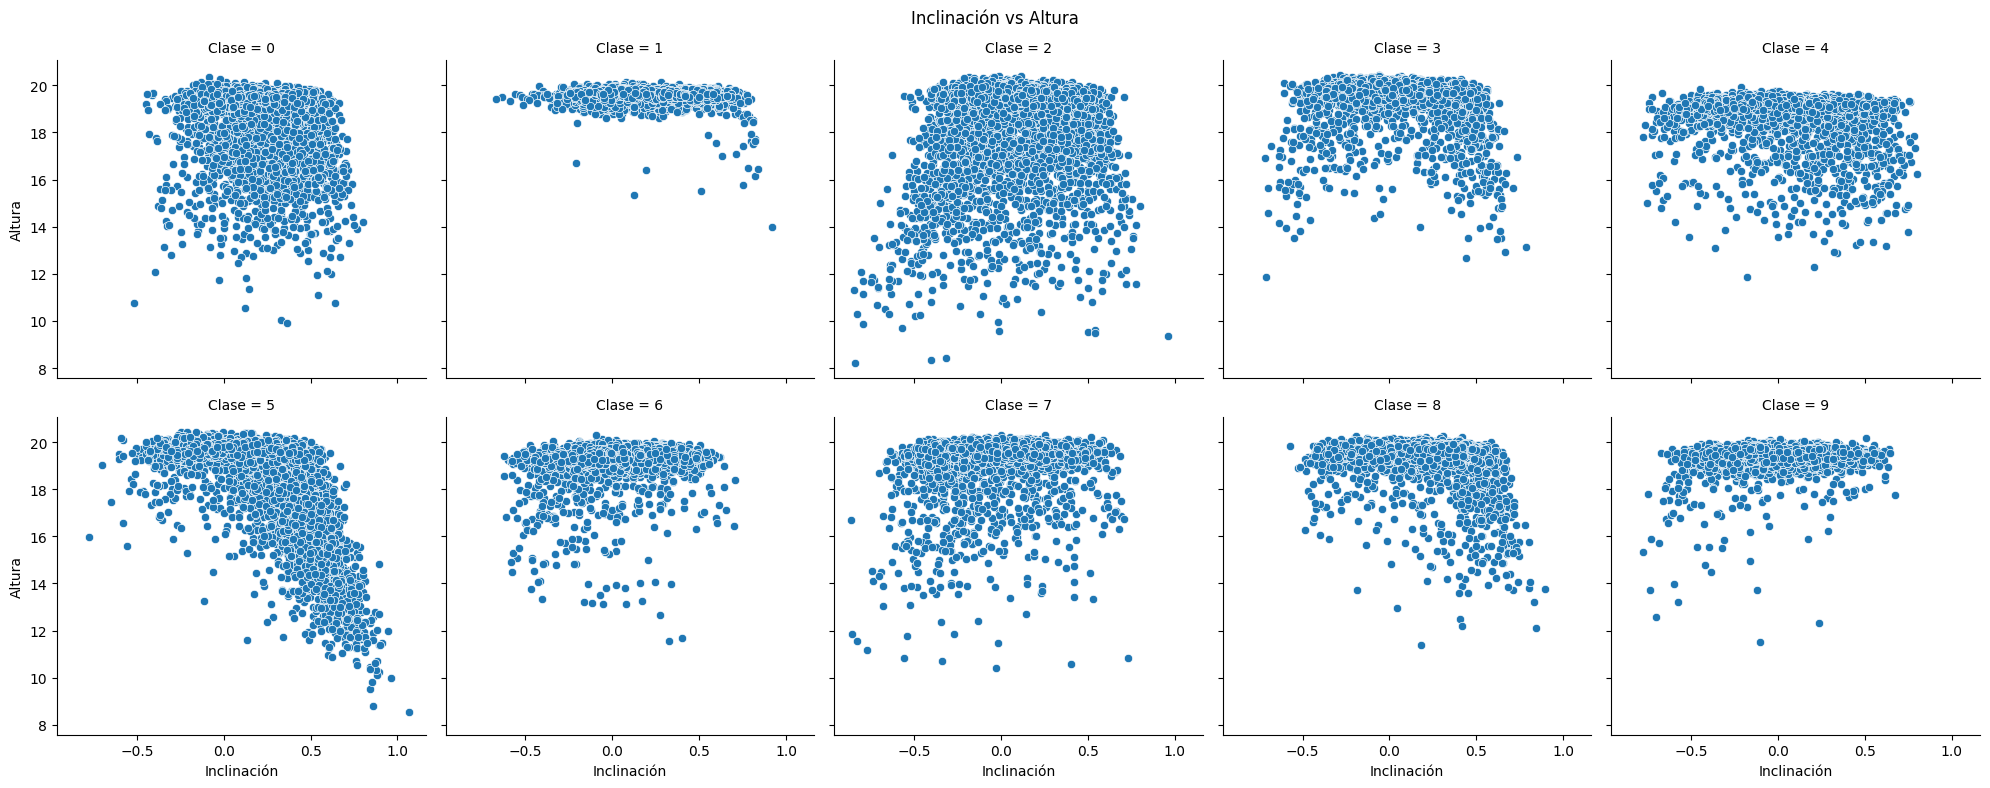

In [ ]:
#Inclinación vs altura

#Junto la información del label 
scatter_data = train_morpho[['slant', 'height']].copy()
scatter_data["Clase"] = y_train

#Grafico los scatter plots
g = sns.FacetGrid(scatter_data, col="Clase", col_wrap=5, height=4)
g.map(sns.scatterplot, 'slant', 'height')

g.set_axis_labels("Inclinación", "Altura")
g.fig.suptitle("Inclinación vs Altura")
plt.tight_layout()

plt.show()

# 4.4 Predicción de la inclinación del número

In [ ]:
#Recupero la información de la inclinación en un arreglo de numpy
slant_train = train_morpho['slant'].values
slant_test = test_morpho['slant'].values

#Normalizo los valores de inclinación para que estén entre cero y uno
slant_train = (slant_train - slant_train.min()) / (slant_train.max() - slant_train.min())
slant_test = (slant_test - slant_test.min()) / (slant_test.max() - slant_test.min())

#Separo el dataset de train en una parte para train y otra para validación (x_train ya está normalizado)
x_train, x_val, y_train, y_val, slant_train, slant_val = model_selection.train_test_split(x_train, y_train, slant_train, test_size=0.2, random_state=42, shuffle=True)

# 4.4.1 Predicción en función de la imagen

In [ ]:
#Construyo el modelo
model = Sequential()
model.add(Flatten(input_shape=[28, 28]))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="linear"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 233,985
Trainable params: 233,985
Non-trai

In [ ]:
#Defino las métricas
metrics = ["mae"]
#Defino el optimizador
optimizer = Adam(learning_rate=0.001)
#Compilo el modelo
model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=metrics)
#Defino callback para Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)

In [ ]:
#Entreno el modelo
history = model.fit(x_train, slant_train, epochs=50, batch_size=32, validation_data=(x_val, slant_val), callbacks=[early_stopping])

Epoch 1/50
1500/1500 [==============================] - 9s 5ms/step - loss: 0.1585 - mae: 0.1585 - val_loss: 0.0929 - val_mae: 0.0929
Epoch 2/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1147 - mae: 0.1147 - val_loss: 0.0718 - val_mae: 0.0718
Epoch 3/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1045 - mae: 0.1045 - val_loss: 0.0794 - val_mae: 0.0794
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1003 - mae: 0.1003 - val_loss: 0.0848 - val_mae: 0.0848
Epoch 5/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0956 - mae: 0.0956 - val_loss: 0.0740 - val_mae: 0.0740
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0932 - mae: 0.0932 - val_loss: 0.0695 - val_mae: 0.0695
Epoch 7/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0918 - mae: 0.0918 - val_loss: 0.0622 - val_mae: 0.0622
Epoch 8/50
1500/1500 [==============================] - 8s 5ms

In [ ]:
#Evalúo los resultados
results_train = model.evaluate(x_train, slant_train)
print("Training Loss: {:.8f}".format(results_train[0]))
print("Training MAE: {:.8f}".format(results_train[1]))
results_val = model.evaluate(x_val, slant_val)
print("Validation Loss: {:.8f}".format(results_val[0]))
print("Validation MAE: {:.8f}".format(results_val[1]))
results_test = model.evaluate(x_test, slant_test)
print("Test Loss: {:.8f}".format(results_test[0]))
print("Test MAE: {:.8f}".format(results_test[1]))

1500/1500 [==============================] - 3s 2ms/step - loss: 0.0404 - mae: 0.0404
Training Loss: 0.04038199
Training MAE: 0.04038199
375/375 [==============================] - 1s 2ms/step - loss: 0.0435 - mae: 0.0435
Validation Loss: 0.04350883
Validation MAE: 0.04350883
313/313 [==============================] - 1s 2ms/step - loss: 0.0778 - mae: 0.0778
Test Loss: 0.07776759
Test MAE: 0.07776759


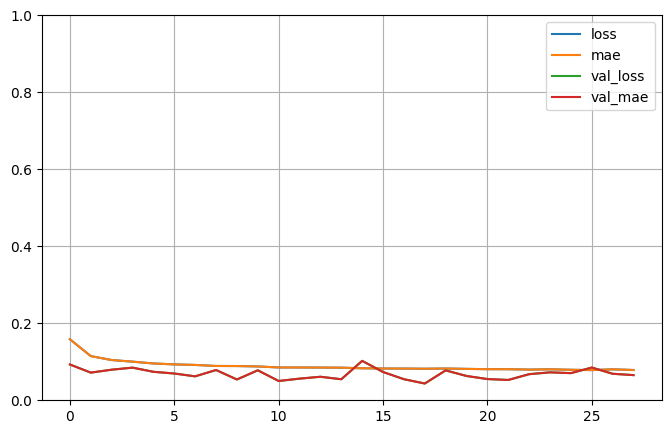

In [ ]:
#Grafico los resultados
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# 4.4.2 Predicción en función de la imagen y el label


La idea ahora es usar la información tanto de la imagen como de la clase a la que pertenece para intentar predecir la inclinación. Se supone que contar además de con la imagen con el label potencialmente permite que el modelo aprende relaciones más complejas y dé mejores resultados.

In [ ]:
#Primero normalizo los valores de los labels para que estén entre cero y uno
labels_train = y_train.astype(float) / 10.0
labels_val = y_val.astype(float) / 10.0
labels_test = y_test.astype(float) / 10.0

In [ ]:
#Creo el modelo (Referencia: https://goodboychan.github.io/python/datacamp/tensorflow-keras/deep_learning/2020/07/27/02-Categorical-Embeddings-Shared-Layers-and-Merge-Layers.html)
image_input = Input(shape=(28, 28))
image_flattened = Flatten()(image_input)

label_input = Input(shape=(1,))
label_embedding = Embedding(input_dim=10, output_dim=2)(label_input)
label_flattened = Flatten()(label_embedding)

merged = concatenate([image_flattened, label_flattened])

hidden_1 = Dense(256, activation="relu")(merged)
hidden_2 = Dropout(0.2)(hidden_1)
hidden_3 = Dense(128, activation="relu")(hidden_2)
hidden_4 = Dropout(0.2)(hidden_3)
output = Dense(1, activation="linear")(hidden_4)
model = Model(inputs=[image_input, label_input], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 2)         20          ['input_8[0][0]']                
                                                                                                  
 flatten_7 (Flatten)            (None, 784)          0           ['input_7[0][0]']                
                                                                                              

In [ ]:
#Defino las métricas
metrics = ["mae"]
#Defino el optimizador
optimizer = Adam(learning_rate=0.001)
#Compilo el modelo
model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=metrics)
#Defino callback para Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)

In [ ]:
#Entreno el modelo
history = model.fit([x_train, y_train], slant_train, epochs=50, batch_size=32, validation_data=([x_val, y_val], slant_val), callbacks=[early_stopping])

Epoch 1/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0482 - mae: 0.0482 - val_loss: 0.0189 - val_mae: 0.0189
Epoch 2/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 3/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0158 - mae: 0.0158 - val_loss: 0.0166 - val_mae: 0.0166
Epoch 5/50
1500/1500 [==============================] - 11s 8ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0203 - val_mae: 0.0203
Epoch 6/50
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0164 - val_mae: 0.0164
Epoch 7/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 8/50
1500/1500 [==============================] - 9s

In [ ]:
#Evalúo los resultados
results_train = model.evaluate([x_train, y_train], slant_train)
print("Training Loss: {:.8f}".format(results_train[0]))
print("Training MAE: {:.8f}".format(results_train[1]))
results_val = model.evaluate([x_val, y_val], slant_val)
print("Validation Loss: {:.8f}".format(results_val[0]))
print("Validation MAE: {:.8f}".format(results_val[1]))
results_test = model.evaluate([x_test, y_test], slant_test)
print("Test Loss: {:.8f}".format(results_test[0]))
print("Test MAE: {:.8f}".format(results_test[1]))

1500/1500 [==============================] - 3s 2ms/step - loss: 0.0088 - mae: 0.0088
Training Loss: 0.00880405
Training MAE: 0.00880405
375/375 [==============================] - 1s 3ms/step - loss: 0.0089 - mae: 0.0089
Validation Loss: 0.00894433
Validation MAE: 0.00894433
313/313 [==============================] - 1s 2ms/step - loss: 0.0473 - mae: 0.0473
Test Loss: 0.04726679
Test MAE: 0.04726679


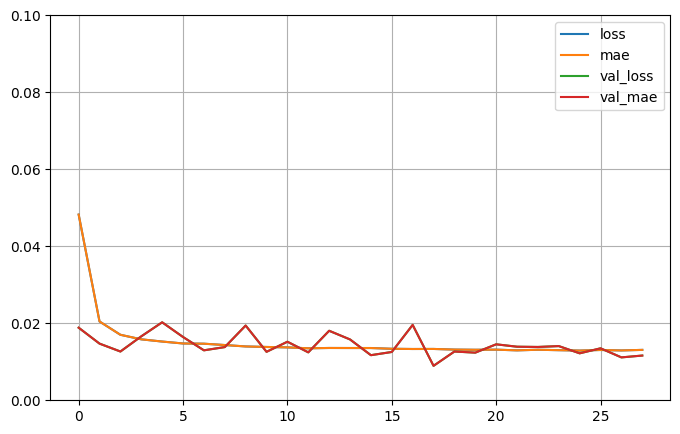

In [ ]:
#Grafico los resultados
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.show()

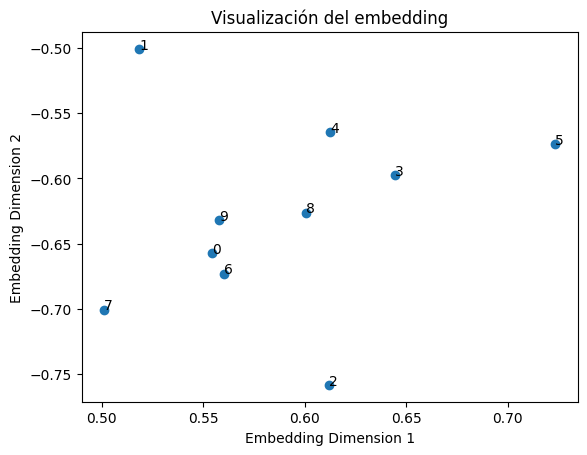

In [ ]:
#Grafico el embedding
embedding_layer = model.get_layer("embedding_4")
weights = embedding_layer.get_weights()[0]
plt.scatter(weights[:, 0], weights[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Visualización del embedding')
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
for i, label in enumerate(labels):
    plt.annotate(label, (weights[i, 0], weights[i, 1]))
plt.show()

# 4.4.3 Predicción a partir de la imagen y la altura


Ahora se busca predecir en función de la imagen y la altura

In [ ]:
#Recupero la información de la altura
height_train = train_morpho['height'].values
height_test = test_morpho['height'].values
#La normalizo para que esté entre cero y uno
height_train = (height_train - height_train.min()) / (height_train.max() - height_train.min())
height_test = (height_test - height_test.min()) / (height_test.max() - height_test.min())
#La separo en train y validation
height_train, height_val = model_selection.train_test_split(height_train, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
#Creo el modelo
image_input = Input(shape=(28, 28))
image_flattened = Flatten()(image_input)

height_input = Input(shape=(1,))

merged = concatenate([image_flattened, height_input])

hidden_1 = Dense(256, activation="relu")(merged)
hidden_2 = Dropout(0.2)(hidden_1)
hidden_3 = Dense(128, activation="relu")(hidden_2)
hidden_4 = Dropout(0.2)(hidden_3)
output = Dense(1, activation="linear")(hidden_4)
model = Model(inputs=[image_input, height_input], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 785)          0           ['flatten[0][0]',                
                                                                  'input_2[0][0]']            

In [ ]:
#Defino las métricas
metrics = ["mae"]
#Defino el optimizador
optimizer = Adam(learning_rate=0.001)
#Compilo el modelo
model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=metrics)
#Defino callback para Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)

In [ ]:
#Entreno el modelo
history = model.fit([x_train, height_train], slant_train, epochs=50, batch_size=32, validation_data=([x_val, height_val], slant_val), callbacks=[early_stopping])

Epoch 1/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0478 - mae: 0.0478 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0169 - mae: 0.0169 - val_loss: 0.0134 - val_mae: 0.0134
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0158 - mae: 0.0158 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 5/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 8/50
1500/1500 [==============================] - 6s 4ms

In [ ]:
#Evalúo los resultados
results_train = model.evaluate([x_train, height_train], slant_train)
print("Training Loss: {:.8f}".format(results_train[0]))
print("Training MAE: {:.8f}".format(results_train[1]))
results_val = model.evaluate([x_val, height_val], slant_val)
print("Validation Loss: {:.8f}".format(results_val[0]))
print("Validation MAE: {:.8f}".format(results_val[1]))
results_test = model.evaluate([x_test, height_test], slant_test)
print("Test Loss: {:.8f}".format(results_test[0]))
print("Test MAE: {:.8f}".format(results_test[1]))

1500/1500 [==============================] - 2s 1ms/step - loss: 0.0098 - mae: 0.0098
Training Loss: 0.00984472
Training MAE: 0.00984472
375/375 [==============================] - 1s 2ms/step - loss: 0.0099 - mae: 0.0099
Validation Loss: 0.00993303
Validation MAE: 0.00993303
313/313 [==============================] - 1s 2ms/step - loss: 0.0503 - mae: 0.0503
Test Loss: 0.05027546
Test MAE: 0.05027546


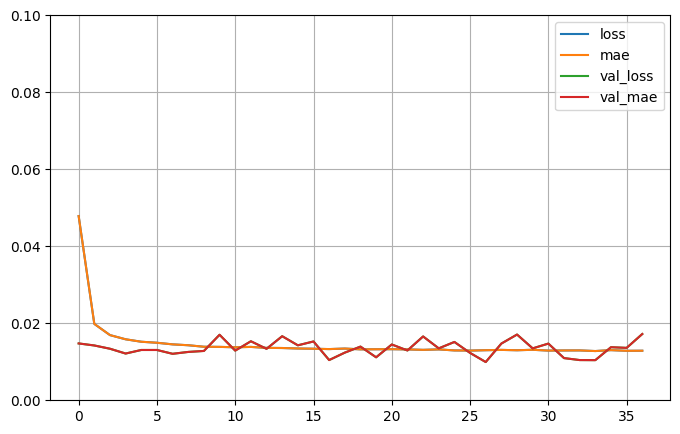

In [ ]:
#Grafico los resultados
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.show()